# Parcel

This is a footnote [^mynote]
{cite:ps}`python2023`

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from core import (
    normality_test,
    plot_sequence,
    add_date_to_data,
    plot_sequence_with_date,
    forecast_multiplicative_trend_and_seasonal,
    compute_descriptive_statistics,
    zero_mean_test,
    constant_variance_test,
    forecast_additive_seasonal,
    randomness_test,
    compute_autocorrelation,
    forecast_simple,
)

In [ ]:
data_path = Path.cwd().parent.parent / "data/Parcel sin tiempo.sav"

Read the data

In [3]:
raw_data = pd.read_spss(data_path)

Plot the data sequentially

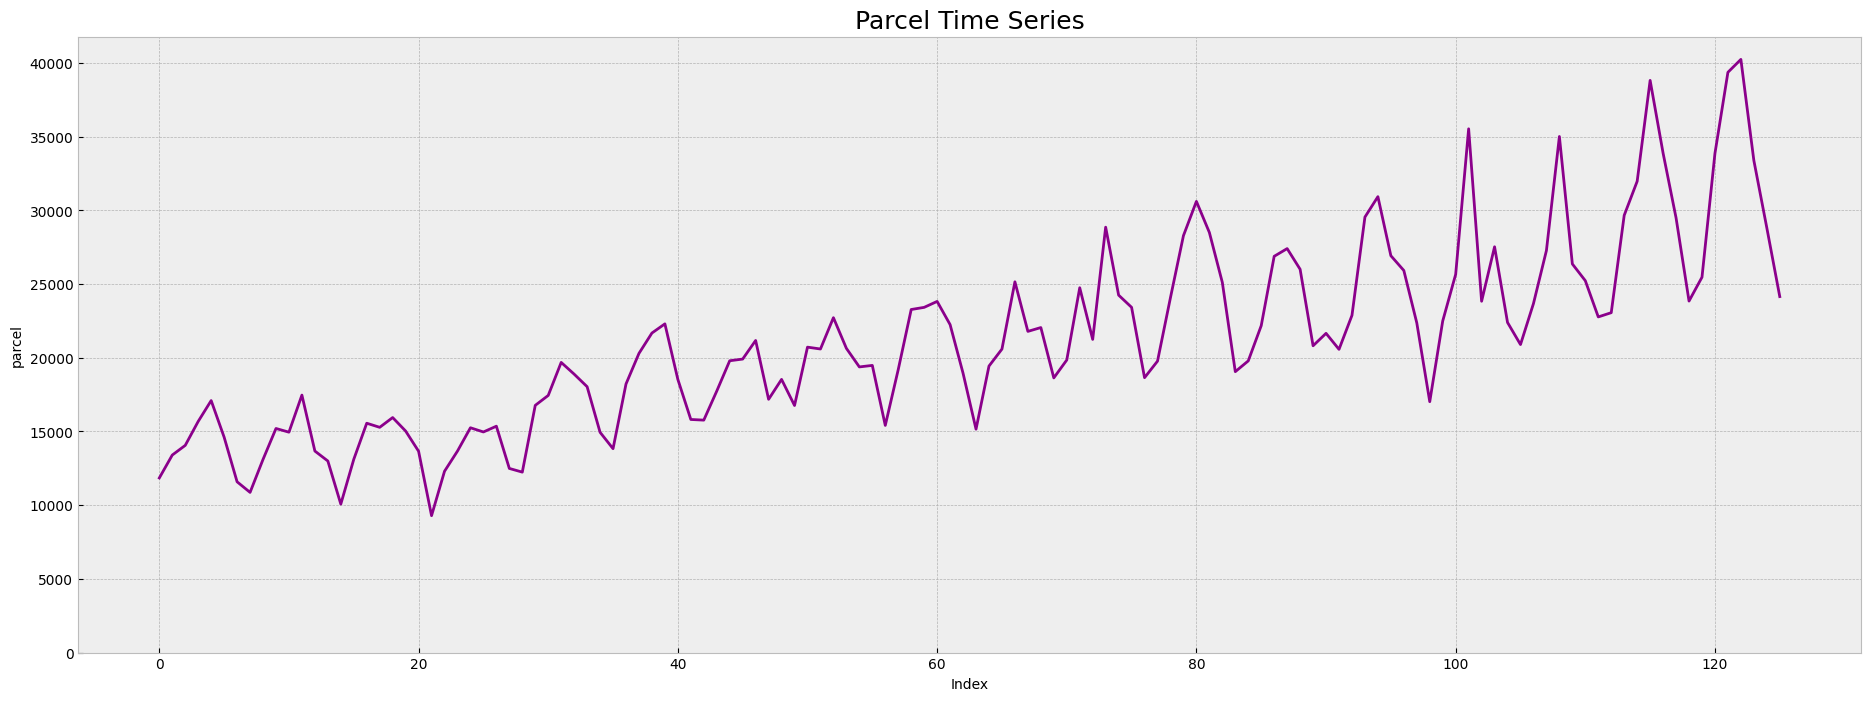

In [4]:
plot_sequence(raw_data.parcel, 'Parcel Time Series');

Adding datetime variables to dataset assuming one observation per day

In [5]:
data_with_dates = add_date_to_data(raw_data)
data_with_dates.head()

,parcel,date,day,week
0,11844.29,1970-01-04,1,1
1,13398.57,1970-01-05,2,2
2,14054.29,1970-01-06,3,2
3,15680.00,1970-01-07,4,2
4,17092.86,1970-01-08,5,2


Plot the data with temporal columns

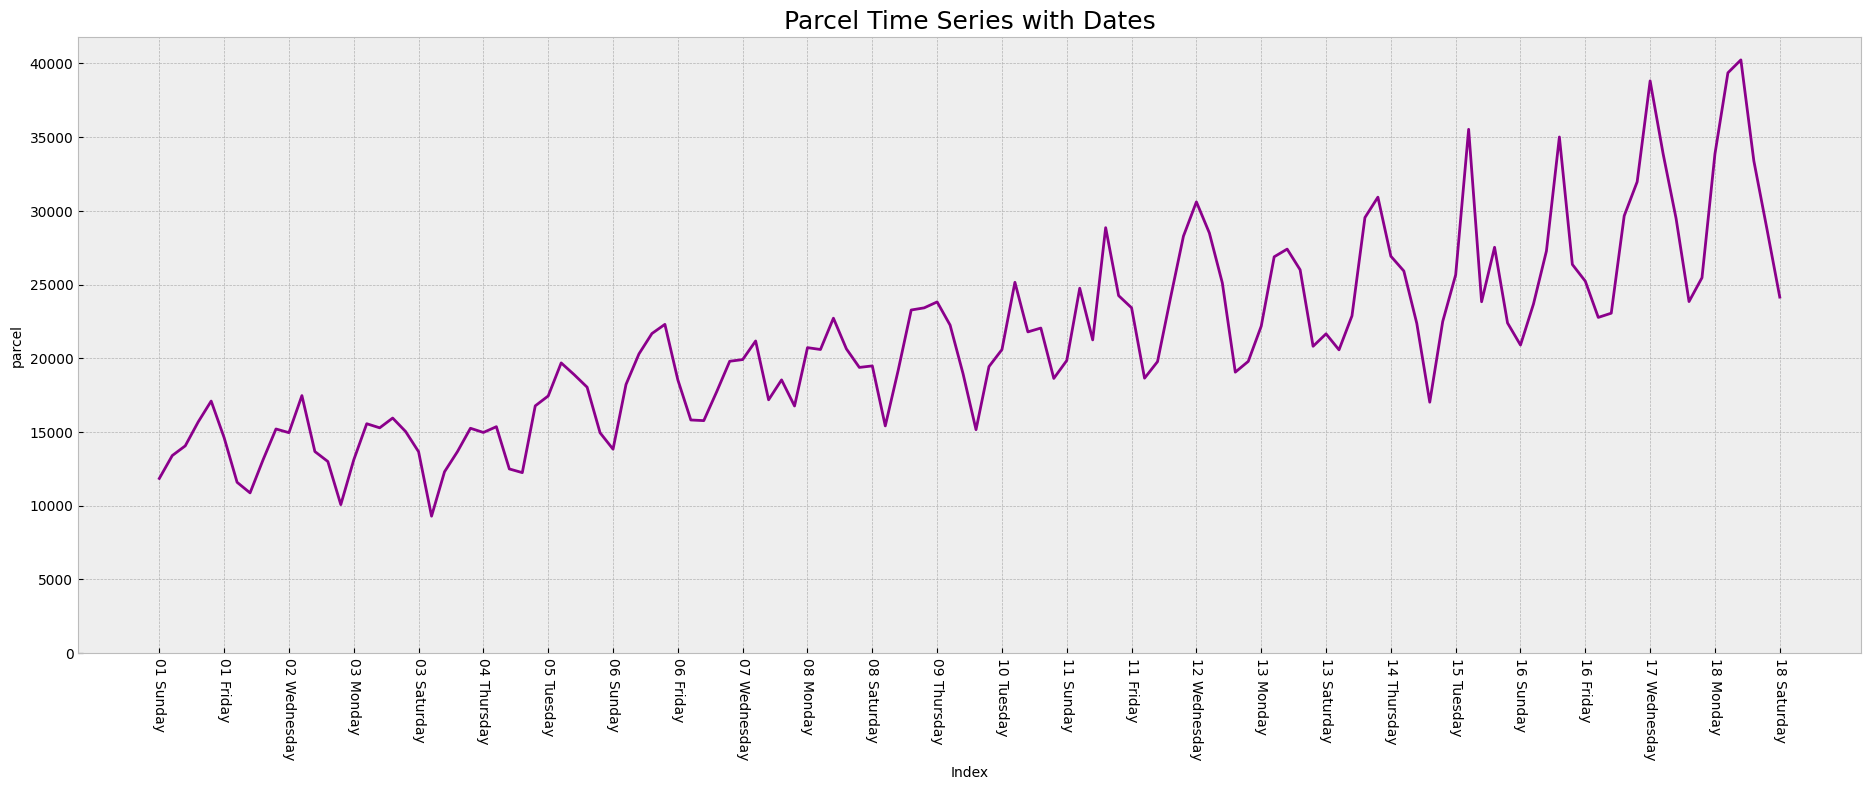

In [6]:
plot_sequence_with_date(data_with_dates, "parcel", "date", 'Parcel Time Series with Dates');

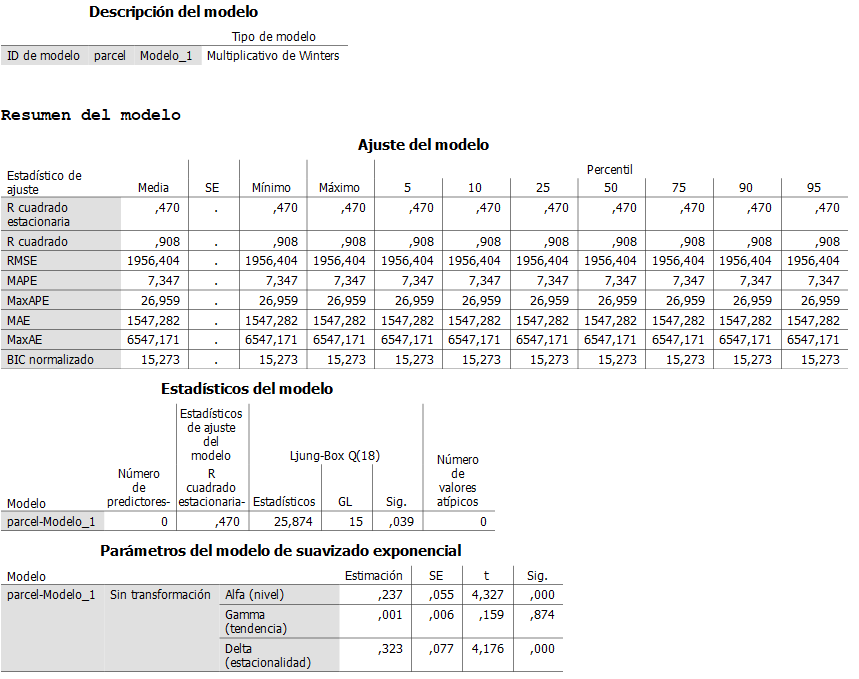

In [7]:
fit_model = forecast_multiplicative_trend_and_seasonal(data_with_dates, "parcel", "date", 7)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

for parameter in fit_model.parameters:
    print(parameter)

RMSE: 1953.591
R^2: 0.906
smoothing_level: 0.2414 ± 0.0451 (0.1521, 0.3306) - t-statistic: 5.3567 - p-value: 0.0000
smoothing_trend: 0.0000 ± nan (nan, nan) - t-statistic: nan - p-value: nan
smoothing_seasonal: 0.2511 ± 0.0630 (0.1264, 0.3758) - t-statistic: 3.9880 - p-value: 0.0001


In [8]:
predictions = fit_model.predict(0, len(data_with_dates)-1)
data_with_forecast = data_with_dates.assign(forecast=predictions.values)
data_with_forecast.head()

,parcel,date,day,week,forecast
0,11844.29,1970-01-04,1,1,14049.943333
1,13398.57,1970-01-05,2,2,14423.695351
2,14054.29,1970-01-06,3,2,15544.289700
3,15680.00,1970-01-07,4,2,16072.629684
4,17092.86,1970-01-08,5,2,16617.514677


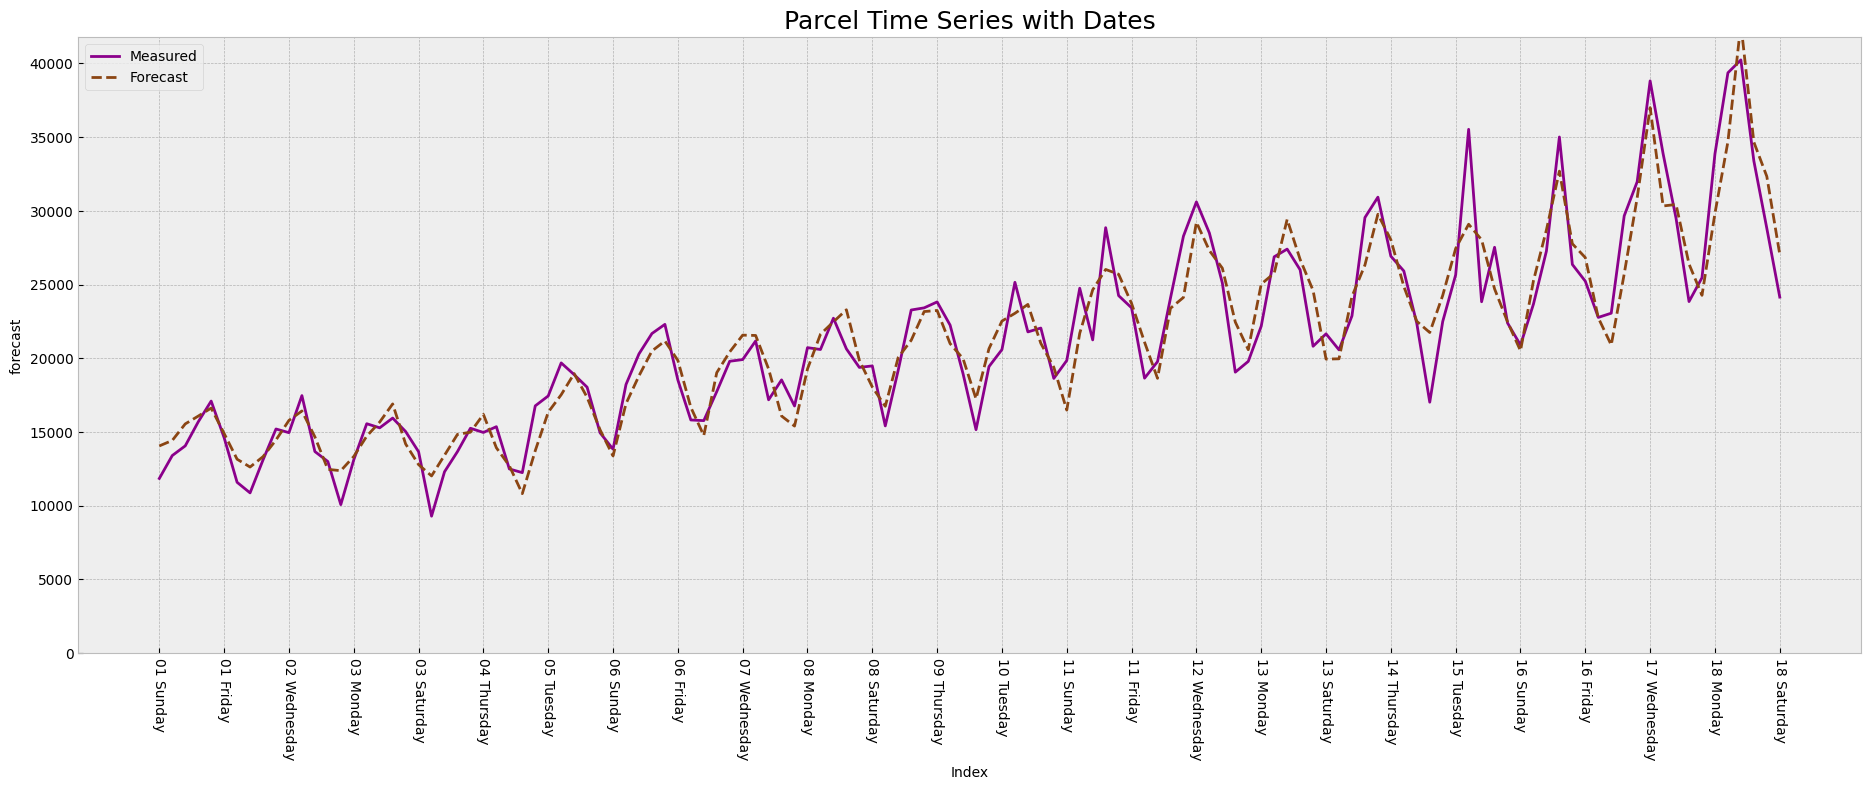

In [9]:
ax = plt.subplot()
plot_sequence_with_date(
    data_with_forecast,
    "parcel",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    label="Measured"
)
plot_sequence_with_date(
    data_with_forecast,
    "forecast",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    ls="--",
    label="Forecast"
)
plt.legend();

It was identified that the trend parameter CI includes zero and thus is not statistically significant. Therefore a different model should be used without a trend component.

In [10]:
fit_model = forecast_additive_seasonal(data_with_dates, "parcel", "date", 7)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

for parameter in fit_model.parameters:
    print(parameter)

RMSE: 2122.685
R^2: 0.889
smoothing_level: 0.3116 ± 0.0744 (0.1642, 0.4589) - t-statistic: 4.1892 - p-value: 0.0001
smoothing_seasonal: 0.3401 ± 0.0811 (0.1794, 0.5008) - t-statistic: 4.1929 - p-value: 0.0001


In [11]:
predictions = fit_model.predict(0, len(data_with_dates)-1)
data_with_forecast_and_residuals = data_with_dates.assign(
                                        forecast=predictions.values,
                                        residuals=fit_model.residuals,
                                    )
data_with_forecast_and_residuals.head()

,parcel,date,day,week,forecast,residuals
0,11844.29,1970-01-04,1,1,13956.599858,-2112.309858
1,13398.57,1970-01-05,2,2,15403.569481,-2004.999481
2,14054.29,1970-01-06,3,2,16599.302790,-2545.012790
3,15680.00,1970-01-07,4,2,15026.157380,653.842620
4,17092.86,1970-01-08,5,2,14540.469892,2552.390108


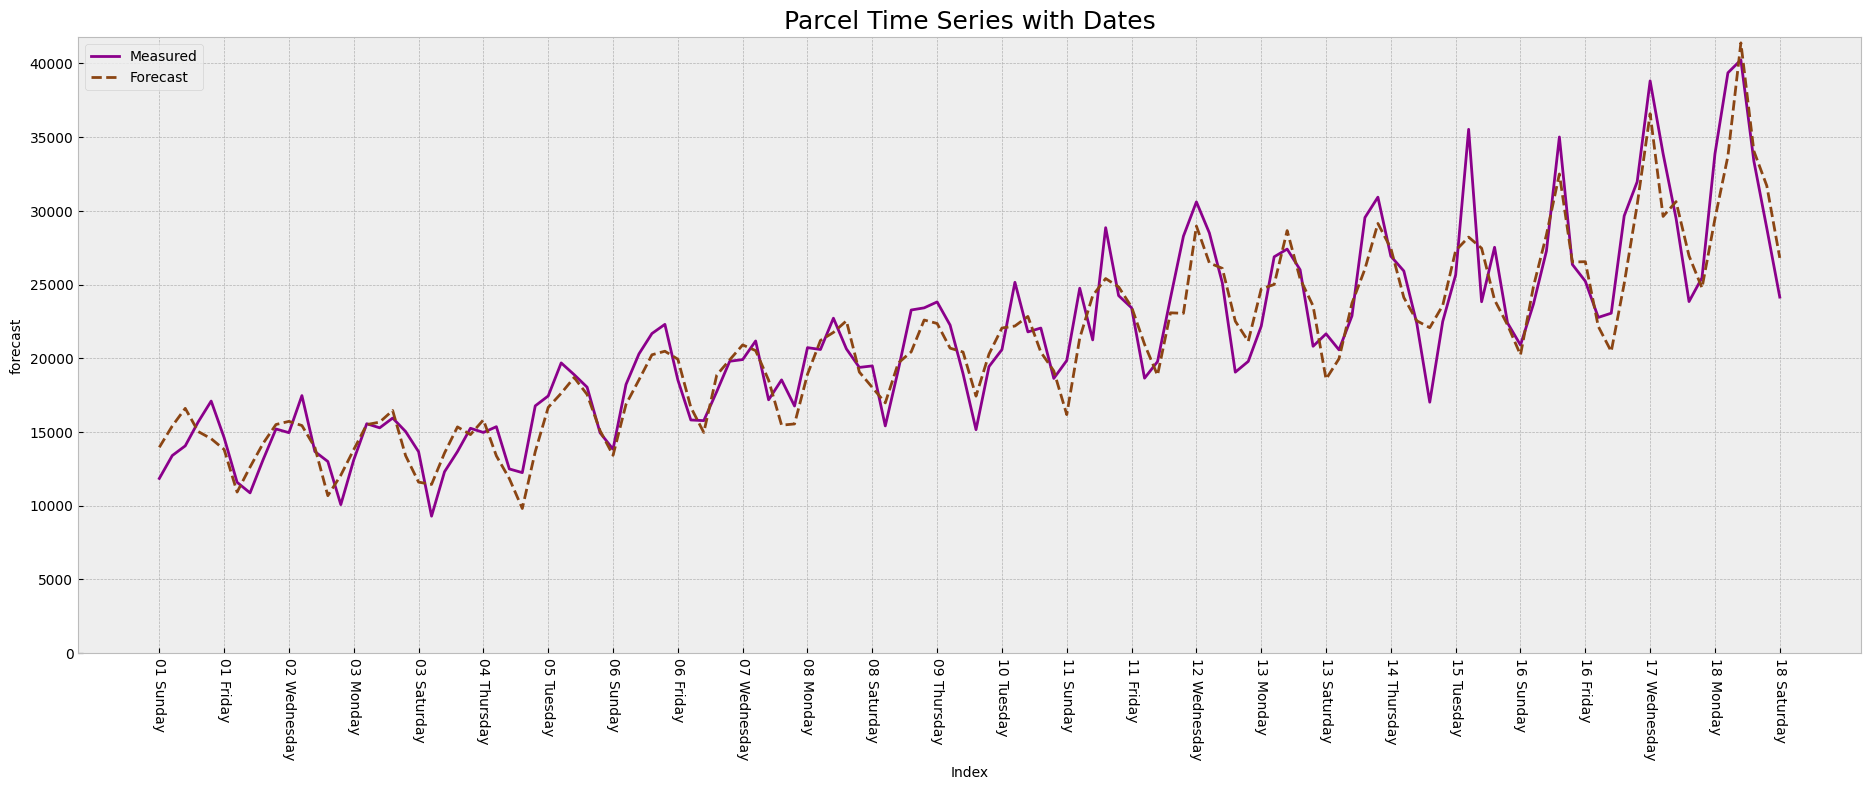

In [12]:
ax = plt.subplot()
plot_sequence_with_date(
    data_with_forecast_and_residuals,
    "parcel",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    label="Measured"
)
plot_sequence_with_date(
    data_with_forecast_and_residuals,
    "forecast",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    ls="--",
    label="Forecast"
)
plt.legend();

# Model Assumptions

1. The residuals should be normally distributed.
2. The residuals should have zero mean.
3. The residuals should have constant variance (homoscedasticity).
4. The residuals should be independent.
5. The residuals should be random

In [13]:
significance = 0.05
residuals = data_with_forecast_and_residuals["residuals"]
descriptive_stats = compute_descriptive_statistics(residuals)
descriptive_stats.show()

{
    "mean": "344.8618",
    "variance": "4421958.5764",
    "standard_deviation": "2102.8454",
    "standard_error": "187.3364"
}


## Test for normality

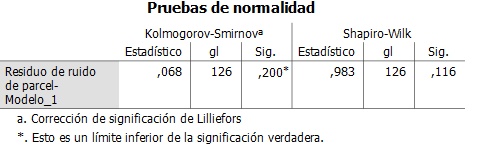

Kolmogorov-Smirnov statistic with Lilliefors correction: 0.0646
Kolmogorov-Smirnov p-value: 0.2709
Shapiro-Wilk statistic: 0.9876
Shapiro-Wilk p-value: 0.3147
Fail to reject null hypothesis: The data may be normally distributed.


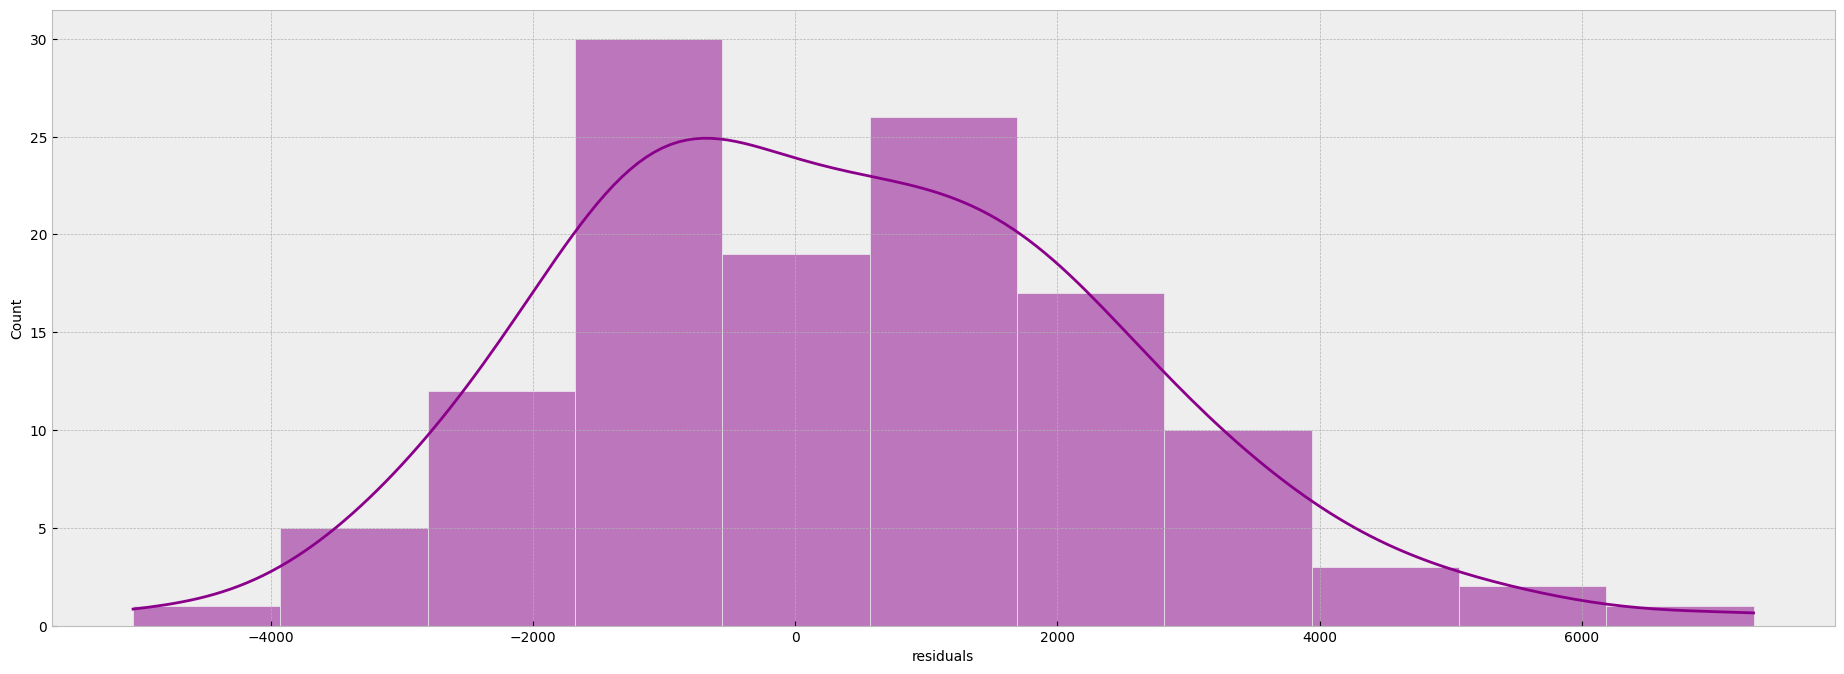

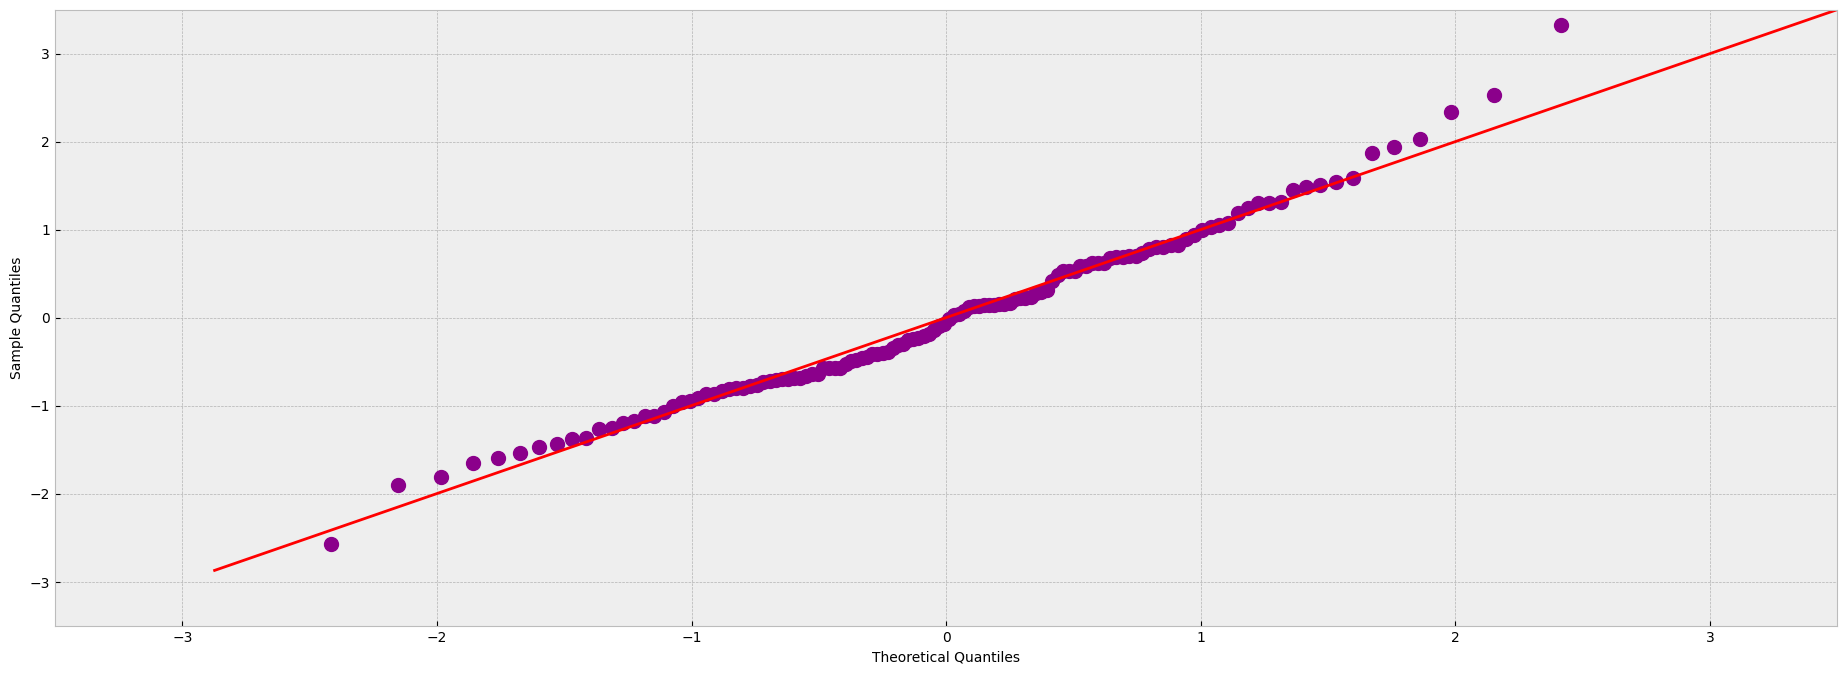

In [14]:
normality_test(residuals, significance_level=significance)

## Test for means Zero

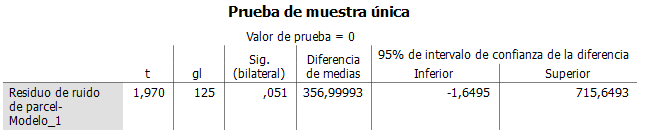

Data mean: 344.8618
t-statistics: 1.8409
p-value: 0.0680
95% CI for Residual Mean: [-26.2155, 715.9390]
Fail to reject null hypothesis: The data may have zero mean.


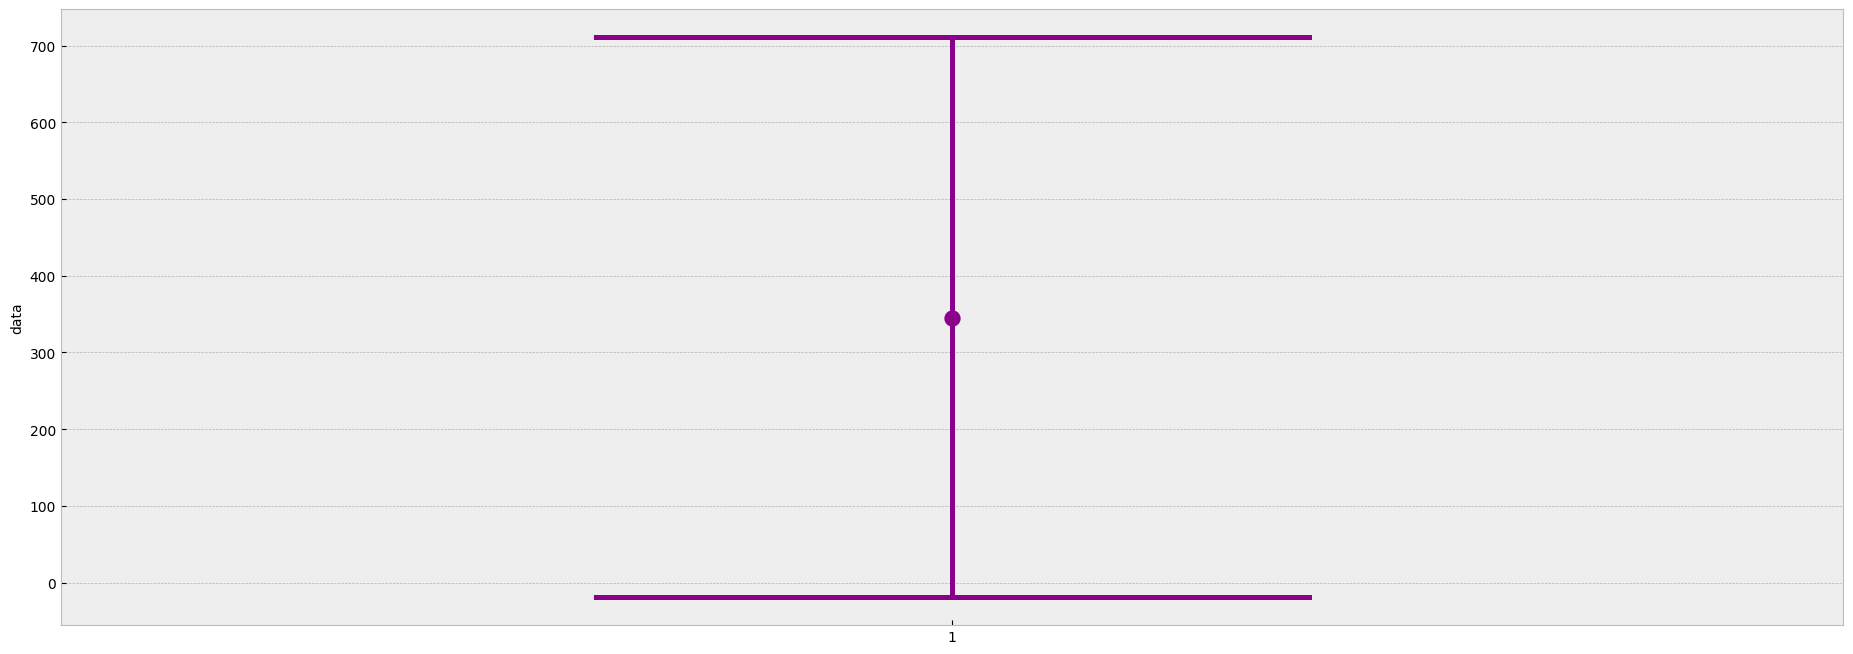

In [15]:
zero_mean_test(
    residuals,
    descriptive_stats,
    degrees_of_freedom=fit_model.degrees_of_freedom,
    significance_level=significance,
)

## Test for constant variance

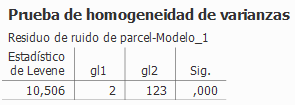

Variances: ['2_278_729', '3_789_533', '7_065_285']
Levene's test statistic: 5.2684
p-value: 0.0064
Reject null hypothesis: Variances are not equal. - Heteroscedasticity detected.


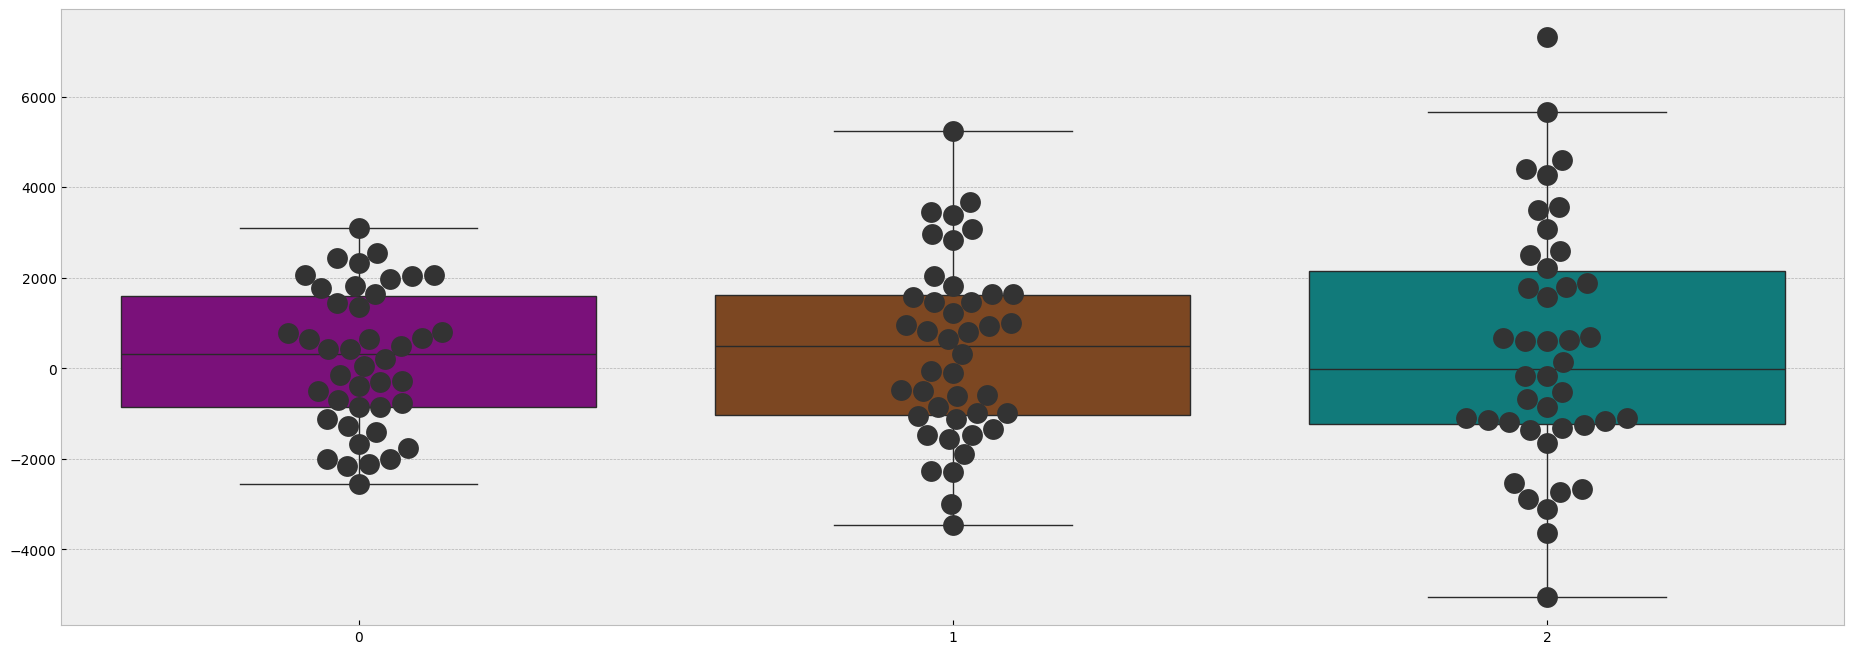

In [16]:
constant_variance_test(residuals, significance_level=significance)

## Test for Independence

Lag 1:   0.034 - 95% CI: [-0.141,  0.209] - p-value: 0.576
Lag 2:   0.086 - 95% CI: [-0.089,  0.260] - p-value: 0.066
Lag 3:  -0.216 - 95% CI: [-0.392, -0.040] - p-value: 0.067
Lag 4:  -0.108 - 95% CI: [-0.292,  0.076] - p-value: 0.052


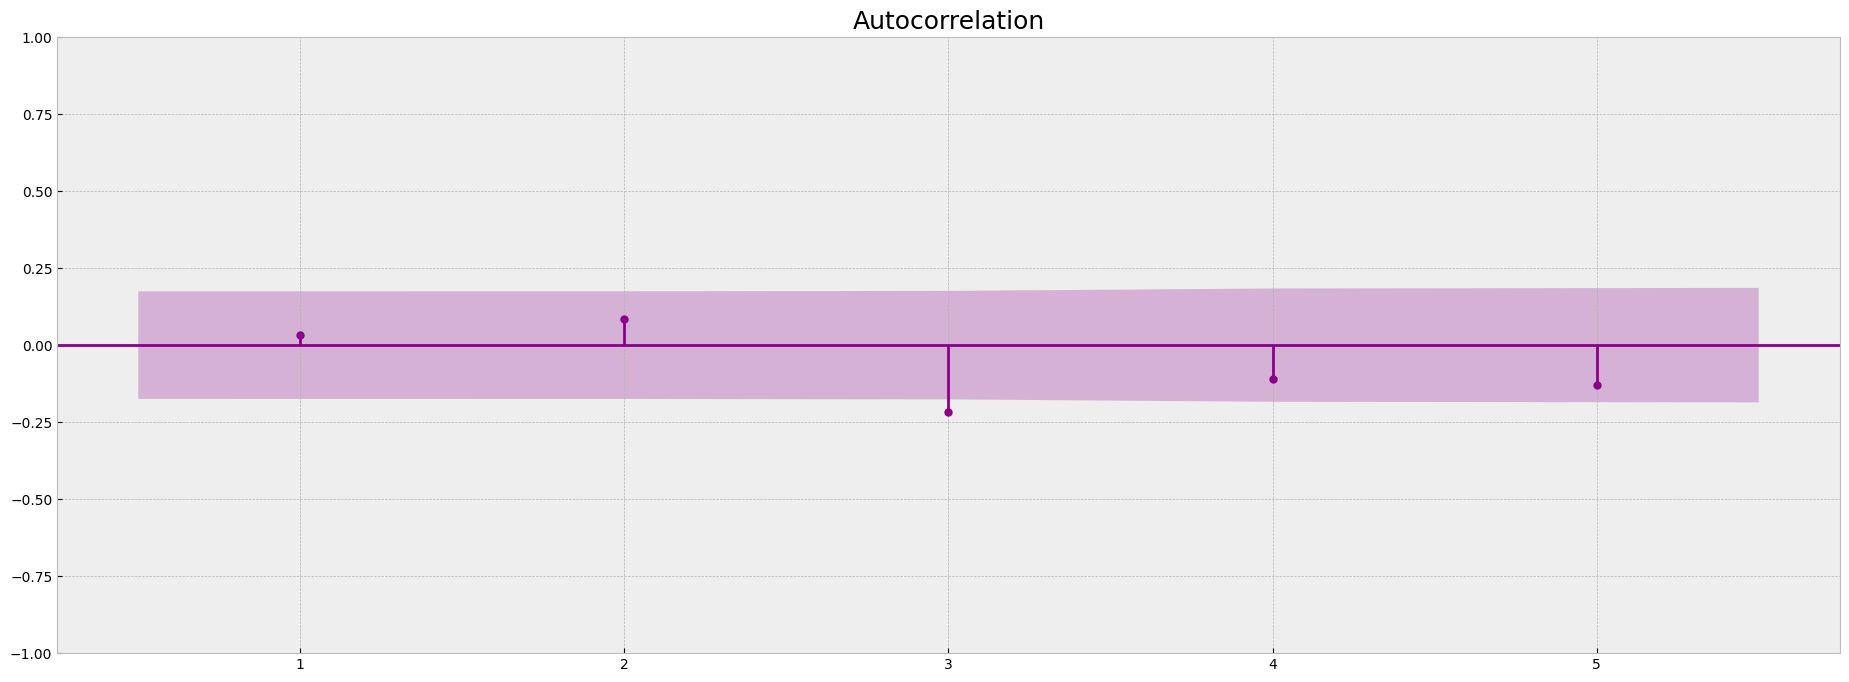

In [17]:
compute_autocorrelation(residuals)

## Test for randomness

z-statistic: -0.534
p-value: 0.593
Fail to reject null hypothesis: The data may be randomly distributed.


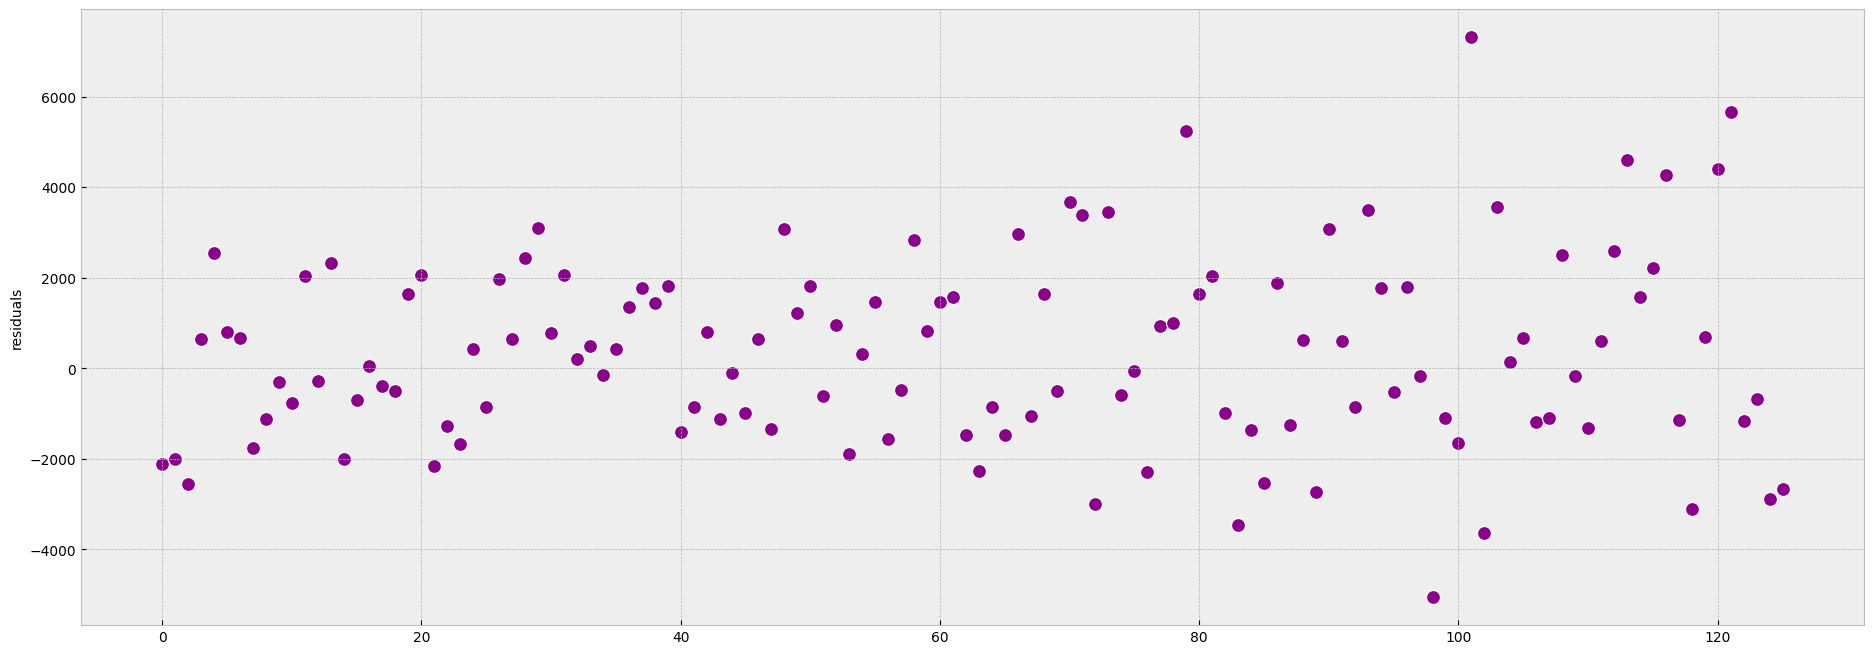

In [18]:
randomness_test(residuals)

## Conclusion

From the following assumptions, one is not fulfilled

1. ✅ The residuals should be normally distributed.
2. ✅ The residuals should have zero mean.
3. ❌The residuals should have constant variance (homoscedasticity).
4. ✅ The residuals should be independent.
5. ✅ The residuals should be random

# Mitigating Heteroskedasticity 

To mitigate this violation, a transformation can be applied to the data prior to training a model. One possible transformation is a running average

In [19]:
data_with_moving_average = data_with_dates.assign(
                                rolling_parcel=lambda df: df["parcel"].rolling(window=5).mean()
                            )
data_with_moving_average

,parcel,date,day,week,rolling_parcel
0,11844.29,1970-01-04,1,1,NaN
1,13398.57,1970-01-05,2,2,NaN
2,14054.29,1970-01-06,3,2,NaN
3,15680.00,1970-01-07,4,2,NaN
4,17092.86,1970-01-08,5,2,14414.002
...,...,...,...,...,...
121,39358.57,1970-05-05,3,19,30401.714
122,40234.29,1970-05-06,4,19,32551.144
123,33384.29,1970-05-07,5,19,34459.430
124,28814.29,1970-05-08,6,19,35130.288


In [20]:
fit_model = forecast_additive_seasonal(data_with_moving_average, "rolling_parcel", "date", 7)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

for parameter in fit_model.parameters:
    print(parameter)

RMSE: 818.458
R^2: 0.977
smoothing_level: 0.6923 ± nan (nan, nan) - t-statistic: nan - p-value: nan
smoothing_seasonal: 0.3077 ± 0.0283 (0.2516, 0.3638) - t-statistic: 10.8698 - p-value: 0.0000


In [21]:
fit_model = forecast_simple(data_with_moving_average, "rolling_parcel", "date", 7)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

for parameter in fit_model.parameters:
    print(parameter)

RMSE: 1031.641
R^2: 0.964
smoothing_level: 0.9999 ± 0.1658 (0.6716, 1.3282) - t-statistic: 6.0310 - p-value: 0.0000


In [22]:
predictions = fit_model.predict(0, len(data_with_moving_average)-1)
data_with_moving_average_forecast_and_residuals = data_with_moving_average.assign(
                                                        forecast=predictions.values,
                                                        residuals=fit_model.residuals,
                                                    )
data_with_moving_average_forecast_and_residuals.head()

,parcel,date,day,week,rolling_parcel,forecast,residuals
4,17092.86,1970-01-08,5,2,14414.002,14198.192001,215.809999
5,14610.00,1970-01-09,6,2,14967.144,14413.980419,553.163581
6,11584.29,1970-01-10,7,2,14604.288,14967.088684,-362.800684
7,10865.71,1970-01-11,1,2,13966.572,14604.324280,-637.752280
8,13101.43,1970-01-12,2,3,13450.858,13966.635775,-515.777775


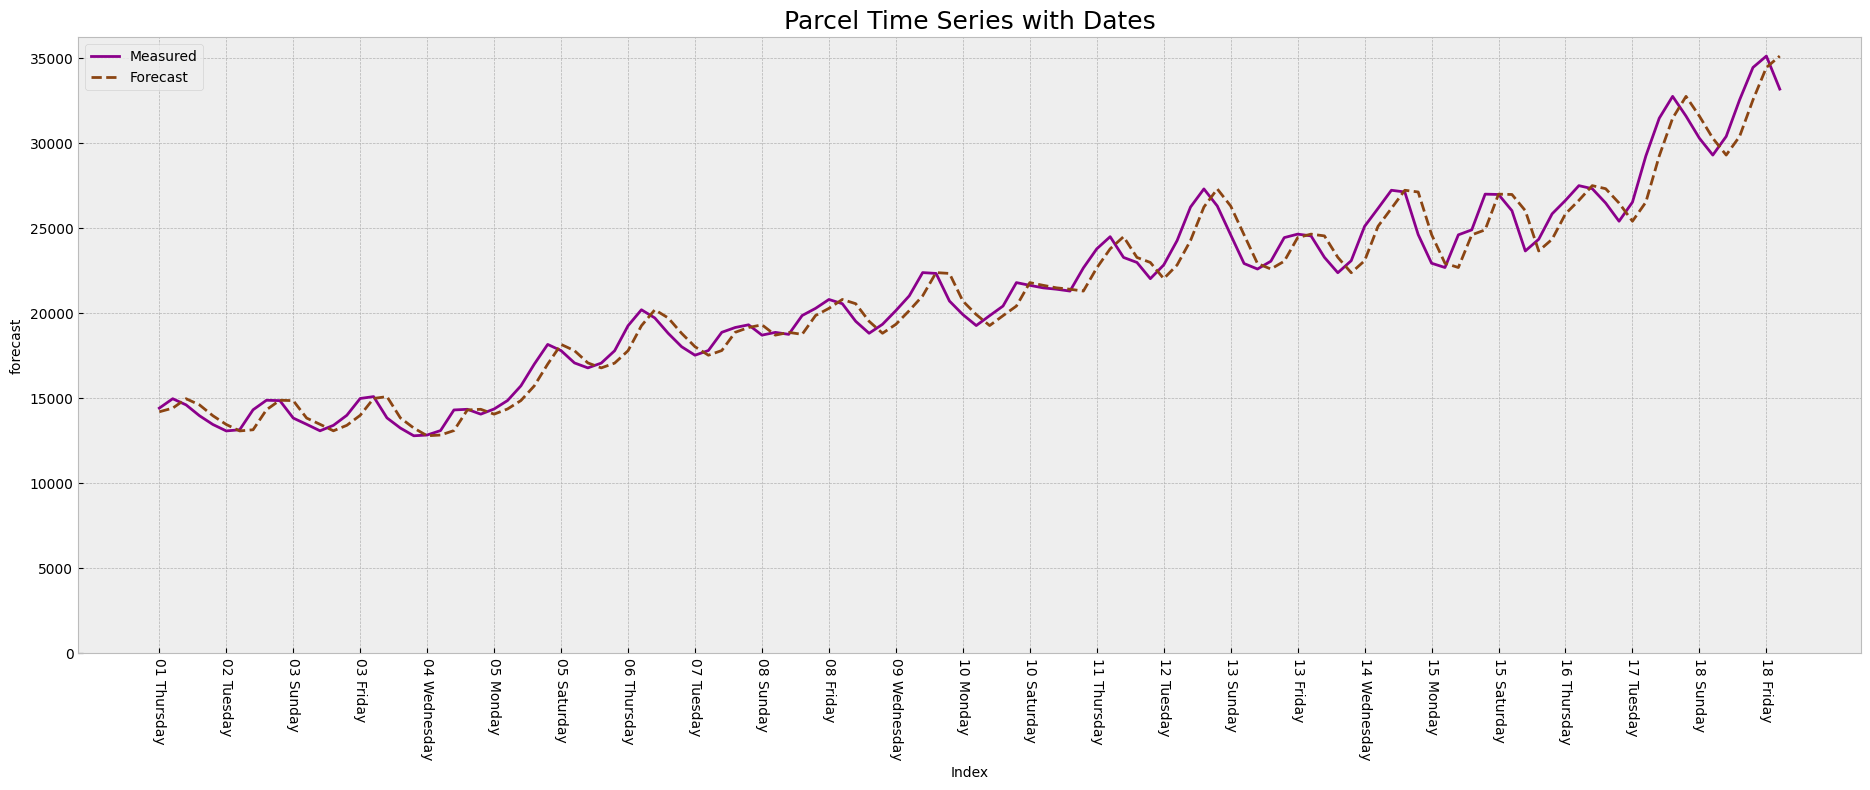

In [23]:
ax = plt.subplot()
plot_sequence_with_date(
    data_with_moving_average_forecast_and_residuals,
    "rolling_parcel",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    label="Measured"
)
plot_sequence_with_date(
    data_with_moving_average_forecast_and_residuals,
    "forecast",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    ls="--",
    label="Forecast"
)
plt.legend();

In [24]:
significance = 0.05
moving_average_residuals = data_with_moving_average_forecast_and_residuals["residuals"]
moving_average_descriptive_stats = compute_descriptive_statistics(moving_average_residuals)
moving_average_descriptive_stats.show()

{
    "mean": "155.6667",
    "variance": "1048647.3372",
    "standard_deviation": "1024.0348",
    "standard_error": "92.7118"
}


## Test for normality

![image.png](attachment:image.png)

Kolmogorov-Smirnov statistic with Lilliefors correction: 0.0392
Kolmogorov-Smirnov p-value: 0.9452
Shapiro-Wilk statistic: 0.9951
Shapiro-Wilk p-value: 0.9492
Fail to reject null hypothesis: The data may be normally distributed.


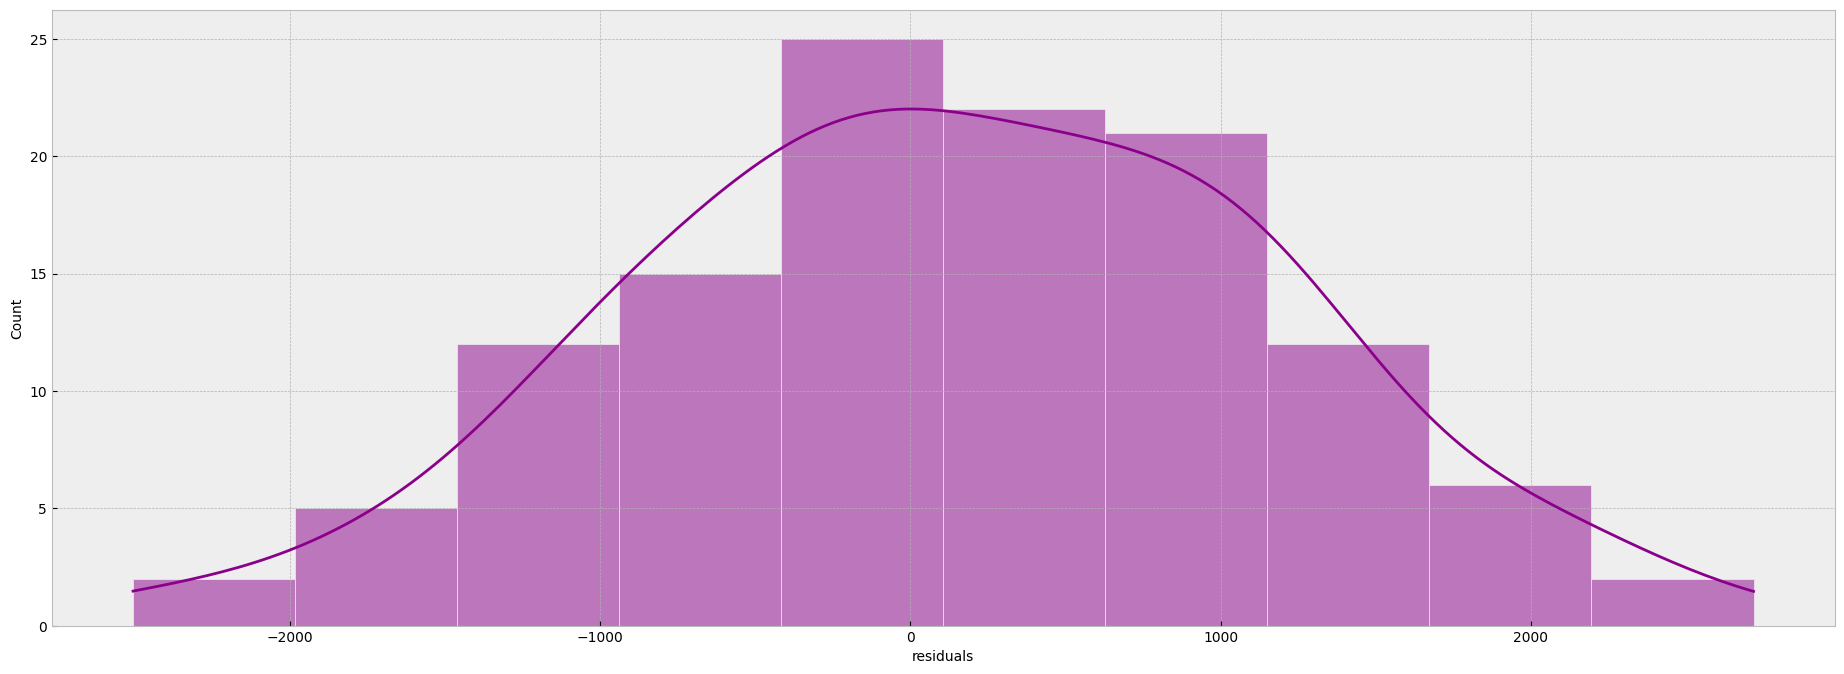

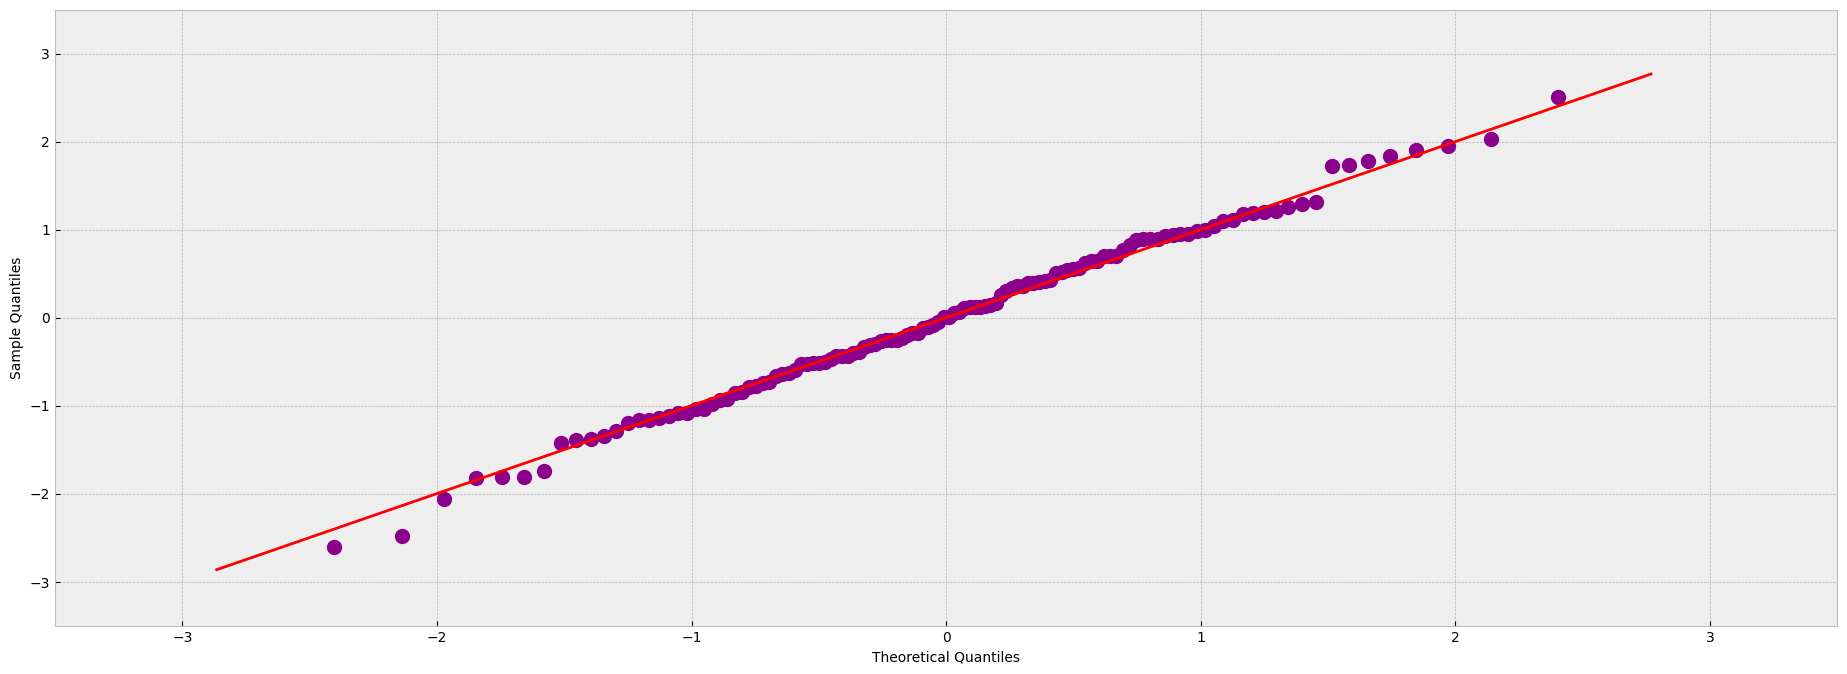

In [25]:
normality_test(moving_average_residuals, significance_level=significance)

## Test for means Zero

![image.png](attachment:image.png)

Data mean: 155.6667
t-statistics: 1.6790
p-value: 0.0957
95% CI for Residual Mean: [-27.9119, 339.2452]
Fail to reject null hypothesis: The data may have zero mean.


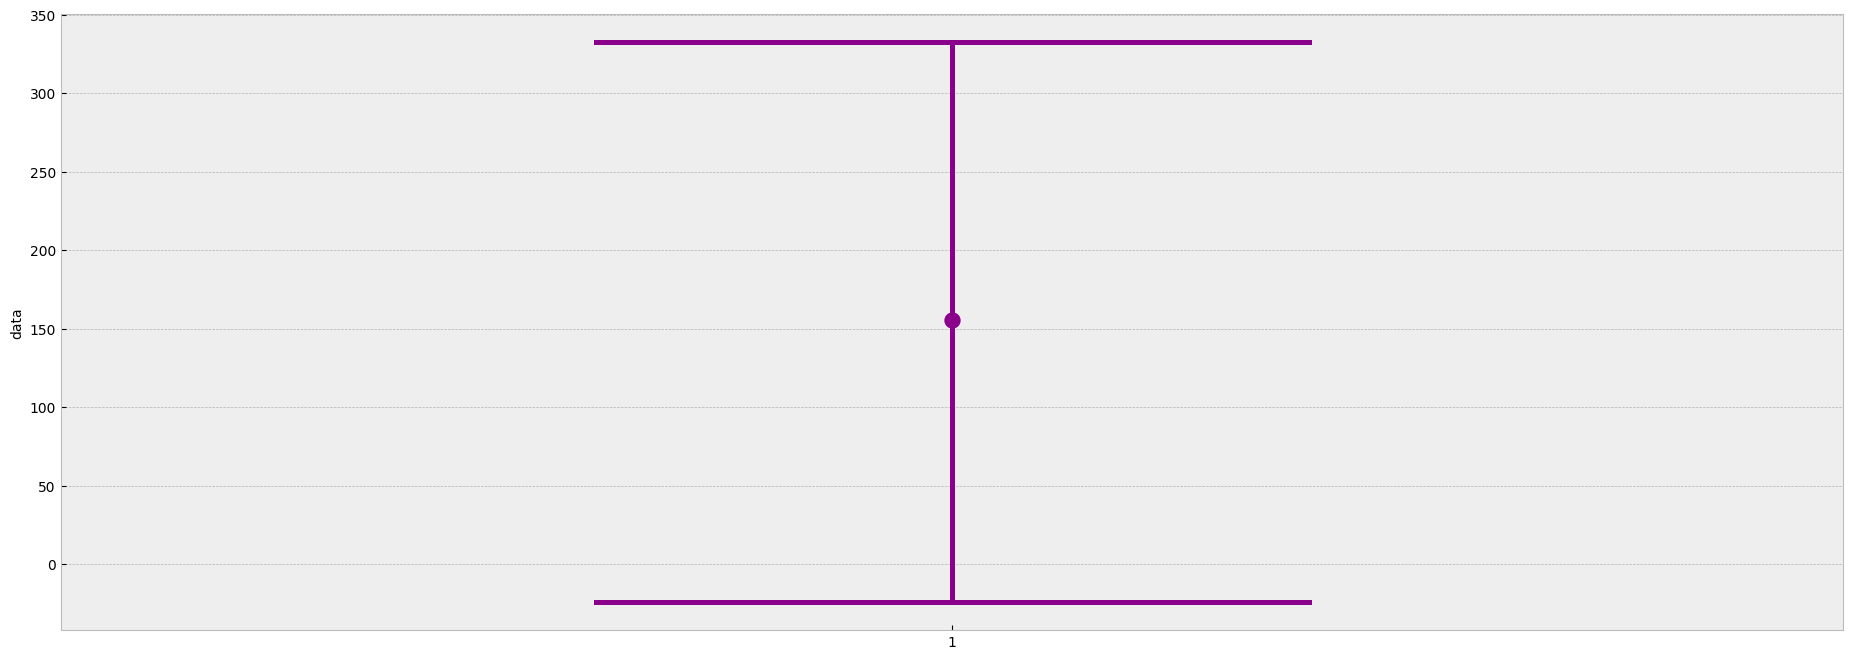

In [26]:
zero_mean_test(
    moving_average_residuals,
    moving_average_descriptive_stats,
    degrees_of_freedom=fit_model.degrees_of_freedom,
    significance_level=significance,
)

## Test for constant variance

![image.png](attachment:image.png)

In [27]:
# constant_variance_test(moving_average_residuals, significance_level=significance)

## Test for Independence

Lag 1:   0.459 - 95% CI: [ 0.281,  0.636] - p-value: 0.000
Lag 2:  -0.139 - 95% CI: [-0.350,  0.073] - p-value: 0.000
Lag 3:  -0.644 - 95% CI: [-0.858, -0.430] - p-value: 0.000
Lag 4:  -0.590 - 95% CI: [-0.858, -0.321] - p-value: 0.000


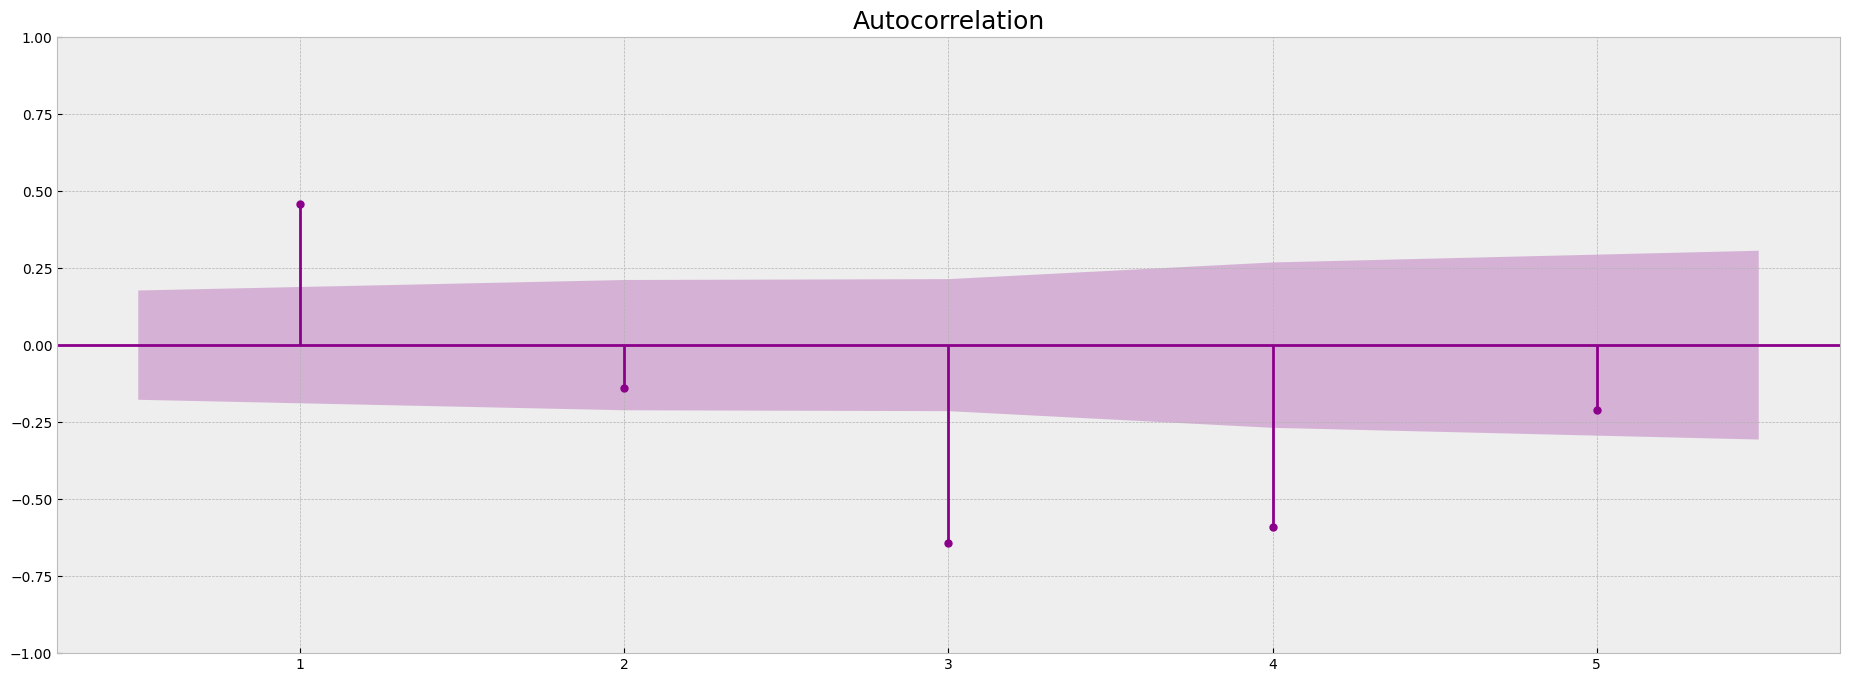

In [28]:
compute_autocorrelation(moving_average_residuals)

## Test for randomness

z-statistic: -4.362
p-value: 0.000
Reject null hypothesis: The data are not randomly distributed.


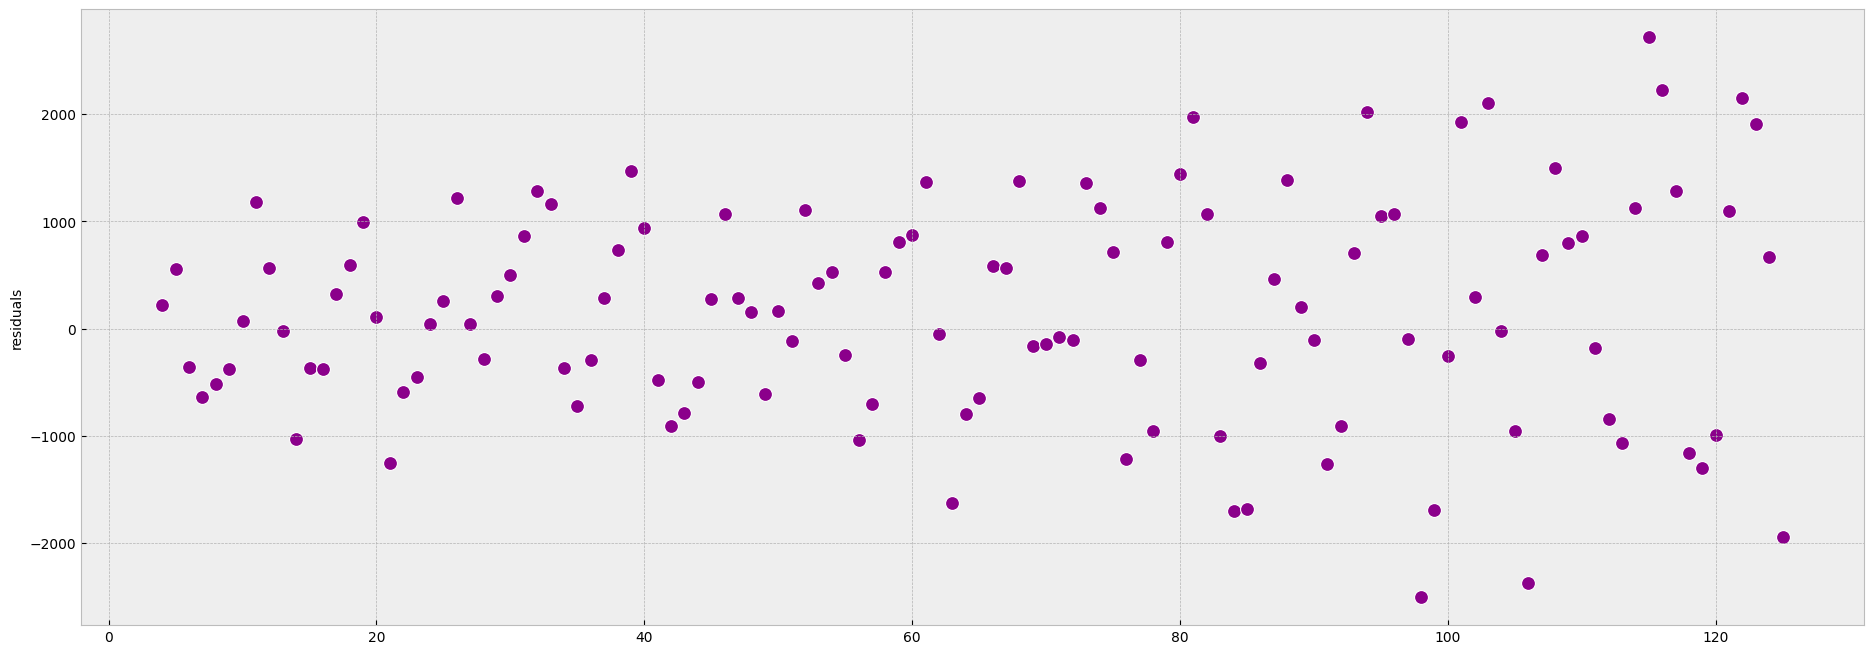

In [29]:
randomness_test(moving_average_residuals)

```{bibliography}
:style: plain
```